In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('gb1')
data_df.head()

,input_ct,selected_ct,hamming_dist,training_set,y,x
0,173.0,33.0,2,True,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,18.0,8.0,2,False,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,66.0,2.0,2,True,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,72.0,1.0,2,False,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,69.0,168.0,2,True,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [3]:
# Split into trianing and test data
ix = data_df['training_set']
L = len(data_df['x'][0])
train_df = data_df[ix]
print(f'training N: {len(train_df):,}')
test_df = data_df[~ix]
print(f'testing N: {len(test_df):,}')

training N: 424,706
testing N: 106,031


In [4]:
# Set filename
name = 'gb1_ge_blackbox'

# Set seeed
mavenn.set_seed(1)

# Define model
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='protein',
                     gpmap_type='mlp',
                     gpmap_kwargs={
                         'hidden_layer_sizes':[100]*5
                     },
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

In [5]:
# Set training data
model.set_data(x=train_df['x'],
               y=train_df['y'])

N = 424,706 observations set as training data.
Data shuffled.
Time to set data: 12.9 sec.


In [6]:
# Fit model to data
history = model.fit(learning_rate=.0003,
                    epochs=1000,
                    batch_size=1000,
                    early_stopping=True,
                    early_stopping_patience=20,
                    linear_initialization=False)

Epoch 1/1000
340/340 [==============================] - 7s 20ms/step - loss: 1108.6633 - I_like: 0.1875 - val_loss: 919.6357 - val_I_like: 0.4465
Epoch 2/1000
340/340 [==============================] - 7s 22ms/step - loss: 800.8022 - I_like: 0.6140 - val_loss: 687.7131 - val_I_like: 0.7743
Epoch 3/1000
340/340 [==============================] - 6s 19ms/step - loss: 581.9561 - I_like: 0.9264 - val_loss: 476.6562 - val_I_like: 1.0777
Epoch 4/1000
340/340 [==============================] - 7s 19ms/step - loss: 384.7212 - I_like: 1.2105 - val_loss: 292.7312 - val_I_like: 1.3430
Epoch 5/1000
340/340 [==============================] - 6s 18ms/step - loss: 209.0537 - I_like: 1.4640 - val_loss: 129.2447 - val_I_like: 1.5792
Epoch 6/1000
340/340 [==============================] - 6s 18ms/step - loss: 67.2678 - I_like: 1.6690 - val_loss: -8.2845 - val_I_like: 1.7782
Epoch 7/1000
340/340 [==============================] - 6s 18ms/step - loss: -60.7907 - I_like: 1.8542 - val_loss: -95.9995 - val_I

In [7]:
# Save model
model.save(name)

Model saved to these files:
	gb1_ge_blackbox.pickle
	gb1_ge_blackbox.h5


In [8]:
# Load model
model = mavenn.load(name)

Model loaded from these files:
	gb1_ge_blackbox.pickle
	gb1_ge_blackbox.h5


In [9]:
!du -k gb1_ge_blackbox.*

640	gb1_ge_blackbox.h5
16	gb1_ge_blackbox.pickle


In [10]:
# Subsample indices for easy plotting and information estimation
N_test = len(test_df)
ix = np.random.rand(N_test) < .1

# Get x and y
x = test_df['x'].values[ix]
y = test_df['y'].values[ix]

On test data:
I_like_test: 2.664 +- 0.019 bits
I_pred_test: 2.750 +- 0.011 bits


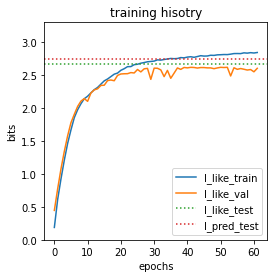

In [11]:
# Show training history
print('On test data:')

# Compute likelihood information
I_like, dI_like =  model.I_likelihood(x=x, y=y)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x, y=y)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_like_hist = model.history['I_like']
val_I_like_hist = model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

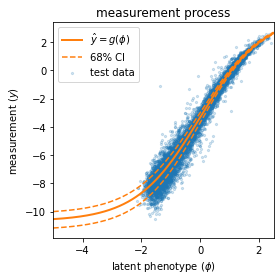

In [12]:
# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

In [13]:
# Test simulate_data
sim_df = model.simulate_dataset(N=1000)
sim_df.head()

,training_set,yhat,phi,y,x
0,True,-0.174869,0.994444,-0.216869,QYKLILNGKTLKGETTTEAVWAATAEKVFKQYANDNGVDGEWTYDD...
1,True,-7.510884,-1.395634,-8.052465,QYKLILNGKTLKGETTTEAVDYATAEKKFSQYANDNGVDGEKTYDD...
2,True,-9.058630,-2.255596,-9.484499,QYKLILNGKTLKGETTTEAVDAATALKVFKSYANANGVDHEWTYDD...
3,False,-2.983343,0.099656,-3.011026,QYKLIGNGKTLKGETTTEAVYSATAEKVFKQYGNDNGTDGEWTYDD...
4,True,-7.645278,-1.454892,-7.471965,QNKLILNGKTLKGETTTEAVDAATAEKVFKQYRNDNGVDGEWTYDD...
